<a href="https://colab.research.google.com/github/Jaydenzk/DS-Unit-2-Applied-Modeling/blob/master/module1/assignment_applied_modeling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin with baselines: majority class baseline for classification, or mean baseline for regression, with your metric of choice.
- [ ] Begin to clean and explore your data.
- [ ] Choose which features, if any, to exclude. Would some features "leak" information from the future?

## Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), **by Lambda DS3 student** Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Video_Games_Sales_as_at_22_Dec_2016.csv to Video_Games_Sales_as_at_22_Dec_2016 (2).csv


In [2]:
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python package:
    # category_encoders, version >= 2.0
    !pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

In [4]:
df.shape

(16719, 16)

In [5]:
df.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [6]:
df.Platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [0]:
## Keep columns's name simple form

df = df.rename(columns={"Year_of_Release": "Year", "NA_Sales": "NA", "EU_Sales": "EU", "JP_Sales": "JP", "Other_Sales": "Other", "Global_Sales": "Global"})
df = df[df["Year"].notnull()]
df = df[df["Genre"].notnull()]
df["Year"] = df["Year"].apply(int)
df["YSR"] = 2018 - df["Year"] ## year since release = YSR

In [8]:
## Basic Model build. Let's drop any NaN values games doesn't have user score, critic score and rating and count

df = df.copy()

df1 = df.dropna(subset=["User_Score", "Critic_Score", "Rating", "User_Count", "Publisher"])
df1.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Count,YSR
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,174.722344,10.563223
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,587.428538,4.211248
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000,2.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,11.000000,7.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,27.000000,11.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,89.000000,14.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,10665.000000,33.000000


In [9]:
df1.head()

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,YSR
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,12
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,10
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,9
6,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E,12
7,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E,12


In [10]:
df1.isnull().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA              0
EU              0
JP              0
Other           0
Global          0
Critic_Score    0
Critic_Count    0
User_Score      0
User_Count      0
Developer       0
Rating          0
YSR             0
dtype: int64

In [0]:
df1 = df1.copy()
df1['Rating'].fillna('NR', inplace= True) # NR means No rating

In [0]:
# Let's make some features

import category_encoders as ce

# numeric columns
numeric = df1.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# categorical column
categorical = df1[["Platform", "Genre", "Rating"]]

# One hot encoder
encoder = ce.one_hot.OneHotEncoder()
categorical = encoder.fit_transform(categorical)

# combine numeric + categorical
features = pd.concat([numeric, categorical], axis = 1)

In [0]:
# train test split target is Global sales

from sklearn.model_selection import train_test_split

target = pd.Series(features["Global"])
features = features.drop(columns="Global")
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [14]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((5460, 40), (1365, 40), (5460,), (1365,))

In [0]:
from sklearn.metrics import mean_absolute_error

In [0]:
# Mean absolute error

def mae(y_true, y_pred):
    return np.average(abs(y_true - y_pred))

In [17]:
base_pred = np.median(target_train)
base_mae = mae(target_test, base_pred)
print("Base global sales {:.02f}".format(base_pred))
print("Base on the test set: MAE {:.04f}".format(base_mae))

Base global sales 0.29
Base on the test set: MAE 0.6879


In [0]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [0]:
# Fit model

def fit_and_evaluate(model):
    
    # Train the model
    model.fit(features_train, target_train)
    
    # Make predictions and evalute
    model_pred = model.predict(features_test)
    model_mae = mae(target_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [20]:
# Let's take a look at Linear Regression

LR = LinearRegression()
LR_mae = fit_and_evaluate(LR)

print("Linear Regression MAE {:.04f}".format(LR_mae))

Linear Regression MAE 0.7147


In [21]:
# Random Forest

random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print("Random Forest MAE {:.04f}".format(random_forest_mae))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest MAE 0.5553


In [22]:
#XGBoost

gradient_boosting = GradientBoostingRegressor(random_state=60)
gradient_boosting_mae = fit_and_evaluate(gradient_boosting)

print("Gradient Boosting MAE {:.04f}".format(gradient_boosting_mae))

Gradient Boosting MAE 0.5294


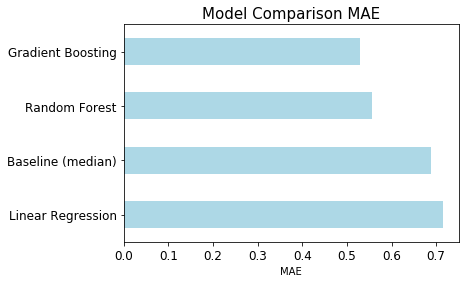

In [23]:
model_comparison = pd.DataFrame({"model": ["Linear Regression", "Random Forest", "Gradient Boosting", "Baseline (median)",], "mae": [LR_mae, random_forest_mae, gradient_boosting_mae, base_mae]})

model_comparison.sort_values("mae", ascending=False).plot(x="model", y="mae", kind="barh", color="lightblue", legend=False)

plt.ylabel(""); plt.yticks(size=12); plt.xlabel("MAE"); plt.xticks(size=12)
plt.title("Model Comparison MAE", size=15);